# Finals MVP Award

In [43]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [44]:
# ================================
# LOAD DATA
# ================================
awards = pd.read_csv("../../initial_data/awards_players.csv")
coaches = pd.read_csv("../../initial_data/coaches.csv")
players_teams = pd.read_csv("../../initial_data/players_teams.csv")
players = pd.read_csv("../../initial_data/players.csv")
series_post = pd.read_csv("../../initial_data/series_post.csv")
teams_post = pd.read_csv("../../initial_data/teams_post.csv")
teams = pd.read_csv("../../initial_data/teams.csv")
mvp_awards = awards[awards["award"] == "WNBA Finals Most Valuable Player"].copy()

## Feature Engineering

In [49]:
# ======================================================
# IMPORTS
# ======================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ======================================================
# HELPER FUNCTIONS
# ======================================================
def calculate_player_score(df):
    """Calculate Game Score for each player."""
    base = (
        df["points"]
        + 0.4 * df["fgMade"]
        - 0.7 * df["fgAttempted"]
        - 0.4 * (df["ftAttempted"] - df["ftMade"])
        + 0.7 * df["oRebounds"]
        + 0.3 * df["dRebounds"]
        + df["steals"]
        + 0.7 * df["assists"]
        + 0.7 * df["blocks"]
        - 0.4 * df["PF"]
        - df["turnovers"]
    )
    df = df.copy()
    df.loc[:, "Game_Score_Total"] = base
    df.loc[:, "Game_Score_Per_Minute"] = base / df["minutes"].replace(0, np.nan)
    return df

def build_player_features(players_teams_df, year):
    """Aggregate per-player features for MVP prediction."""
    df_prev = players_teams_df[players_teams_df["year"] == year - 1].copy()
    
    # Aggregate if multiple stints exist
    df_prev_agg = df_prev.groupby("playerID").agg({
        "tmID": "first",  # assume first team is representative
        "minutes": "sum",
        "points": "sum",
        "oRebounds": "sum",
        "dRebounds": "sum",
        "assists": "sum",
        "steals": "sum",
        "blocks": "sum",
        "turnovers": "sum",
        "PF": "sum",
        "fgAttempted": "sum",
        "fgMade": "sum",
        "ftAttempted": "sum",
        "ftMade": "sum"
    }).reset_index()
    
    df_prev_agg = calculate_player_score(df_prev_agg)
    
    player_features = df_prev_agg[[
        "playerID", "tmID", "minutes", "Game_Score_Total", "Game_Score_Per_Minute"
    ]]
    
    return player_features

def build_team_features(players_teams_df, teams_df, year):
    """Compute team weighted score from previous season player stats."""
    team_features = []
    team_ids = teams_df[teams_df["year"] == year]["tmID"].unique()
    
    for team in team_ids:
        df_team = players_teams_df[(players_teams_df["year"] == year - 1) & (players_teams_df["tmID"] == team)]
        if df_team.empty:
            weighted_score = 0
        else:
            df_team = calculate_player_score(df_team)
            total_weight = df_team["Game_Score_Total"].sum()
            if total_weight == 0 or np.isnan(total_weight):
                weighted_score = 0
            else:
                weighted_score = ((df_team["Game_Score_Per_Minute"] * df_team["Game_Score_Total"]).sum() / total_weight)
        team_features.append({"tmID": team, "Team_Weighted_Score": weighted_score})
    
    return pd.DataFrame(team_features)

def merge_player_team_features(player_features, team_features, teams_df):
    # Keep only unique teams
    team_features_unique = team_features[['tmID', 'Team_Weighted_Score', 'Finals_Probability', 'Conference', 'year']].drop_duplicates()
    
    df = player_features.merge(team_features_unique, on='tmID', how='left')
    # Make sure each player appears only once
    df = df.drop_duplicates(subset=['playerID'])
    
    # Optional: merge conference info from teams_df for completeness
    df = df.merge(teams_df[["tmID", "year", "confID"]].drop_duplicates(), on=["tmID", "year"], how="left")
    df.rename(columns={"confID": "Conference"}, inplace=True)
    
    return df


# ======================================================
# CONFERENCE-BASED FINALS PROBABILITY
# ======================================================
def predict_team_finals_prob_by_conf(team_features, teams_df, year):
    """Compute Finals probability per team (unique per team)."""
    team_features = team_features.merge(teams_df[["tmID", "confID", "year"]], on="tmID", how="left")
    team_features = team_features[team_features["year"] == year]
    team_features.rename(columns={"confID": "Conference"}, inplace=True)

    finals_probs = []
    for conf in ["EA", "WE"]:
        conf_teams = team_features[team_features["Conference"] == conf].copy()
        total_score = conf_teams["Team_Weighted_Score"].sum()
        if total_score > 0:
            conf_teams["Finals_Probability"] = conf_teams["Team_Weighted_Score"] / total_score
        else:
            conf_teams["Finals_Probability"] = 0
        finals_probs.append(conf_teams)
    
    team_features_unique = pd.concat(finals_probs, ignore_index=True)
    # Ensure one row per team
    team_features_unique = team_features_unique.drop_duplicates(subset=["tmID", "year"])
    
    return team_features_unique


def predict_player_mvp_prob_by_conf(df):
    df["MVP_Score"] = df["Game_Score_Per_Minute"] * df["Finals_Probability"]
    df["MVP_Probability"] = df["MVP_Score"] / df["MVP_Score"].sum()
    return df.sort_values("MVP_Probability", ascending=False)

# ======================================================
# HISTORICAL DATASET FOR ML TRAINING
# ======================================================
def build_historical_dataset(players_teams_df, teams_df, mvp_df, start_year, end_year):
    all_data = []
    for year in range(start_year + 1, end_year + 1):
        player_features = build_player_features(players_teams_df, year)
        team_features = build_team_features(players_teams_df, teams_df, year)
        team_features = predict_team_finals_prob_by_conf(team_features, teams_df, year)
        
        df = merge_player_team_features(player_features, team_features, teams_df)
        df["Finals_MVP"] = df["playerID"].apply(
            lambda pid: 1 if ((mvp_awards["year"] == year) & (mvp_awards["playerID"] == pid)).any() else 0
        )
        all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

# ======================================================
# DATA PREPARATION & MODEL TRAINING
# ======================================================
def prepare_data(df):
    feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                    "Team_Weighted_Score", "Finals_Probability"]
    X = df[feature_cols].fillna(0)
    y = df["Finals_MVP"]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def train_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(
        n_estimators=500,
        max_depth=5,
        class_weight="balanced",
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    return model

# ======================================================
# PRESEASON MVP PREDICTION
# ======================================================
def preseason_mvp_ml_prediction(model, players_teams_df, teams_df, year):
    player_features = build_player_features(players_teams_df, year)
    team_features = build_team_features(players_teams_df, teams_df, year)
    team_features = predict_team_finals_prob_by_conf(team_features, teams_df, year)
    
    df = merge_player_team_features(player_features, team_features, teams_df)
    assert df['playerID'].duplicated().sum() == 0, "Duplicate players still exist!"
    
    feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                    "Team_Weighted_Score", "Finals_Probability"]
    
    X_pred = df[feature_cols].fillna(0)
    df["MVP_Probability"] = model.predict_proba(X_pred)[:, 1]
    
    return df.sort_values("MVP_Probability", ascending=False)[
        ["playerID", "tmID", "Conference", "MVP_Probability"]
    ]

# ======================================================
# EXAMPLE USAGE
# ======================================================
historical_df = build_historical_dataset(players_teams, teams, awards, 2, 10)
historical_df.to_csv("mvp_historical_dataset.csv", index=False)
X_train, X_test, y_train, y_test = prepare_data(historical_df)
model = train_model(X_train, y_train, X_test, y_test)
preseason_mvp = preseason_mvp_ml_prediction(model, players_teams, teams, 10)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       287
           1       0.00      0.00      0.00         2

    accuracy                           0.99       289
   macro avg       0.50      0.50      0.50       289
weighted avg       0.99      0.99      0.99       289



c:\Users\tadeu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tadeu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tadeu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Evaluation

### Hit Rate

In [46]:
# ======================================================
# ENHANCED EVALUATION SCRIPT
# ======================================================
def evaluate_mvp_model_with_rank(model, players_teams_df, teams_df, mvp_df, top_n=5, start_year=1, end_year=10):
    """
    Evaluate the model by checking if the actual Finals MVP
    is among the top N predicted candidates each season and
    also record the actual MVP's rank.
    
    Returns a DataFrame with season-level results and overall coverage.
    """
    results = []

    for year in range(start_year, end_year + 1):
        # Build player features for the season
        player_features = build_player_features(players_teams_df, year)
        team_features = build_team_features(players_teams_df, teams_df, year)
        team_features = predict_team_finals_prob_by_conf(team_features, teams_df, year)
        df = merge_player_team_features(player_features, team_features, teams_df)

        # Predict MVP probabilities
        feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                        "Team_Weighted_Score", "Finals_Probability"]
        X_pred = df[feature_cols].fillna(0)
        df["MVP_Probability"] = model.predict_proba(X_pred)[:, 1]

        # Sort all players by predicted probability
        df_sorted_all = df.sort_values("MVP_Probability", ascending=False).reset_index(drop=True)

        # Get top N candidates
        df_sorted_topn = df_sorted_all.head(top_n)

        # Actual MVP
        actual_mvp = mvp_awards[mvp_awards["year"] == year]["playerID"].values
        if len(actual_mvp) == 0:
            actual_mvp_id = None
            hit = False
            rank = None
        else:
            actual_mvp_id = actual_mvp[0]
            # Check if in top N
            hit = actual_mvp_id in df_sorted_topn["playerID"].values
            # Get rank in full sorted list (1 = highest probability)
            ranks = df_sorted_all.reset_index()
            rank_row = ranks[ranks["playerID"] == actual_mvp_id]
            rank = int(rank_row["index"].values[0] + 1) if not rank_row.empty else None

        results.append({
            "year": year,
            "actual_mvp": actual_mvp_id,
            "top_candidates": df_sorted_topn["playerID"].tolist(),
            "hit_top_n": hit,
            "actual_mvp_rank": rank
        })

    results_df = pd.DataFrame(results)
    coverage = results_df["hit_top_n"].mean() * 100
    avg_rank = results_df["actual_mvp_rank"].dropna().mean()
    print(f"Coverage: {coverage:.2f}% of actual Finals MVPs were in top {top_n} candidates.")
    print(f"Average rank of actual MVP across seasons: {avg_rank:.2f}")

    return results_df

# ======================================================
# EXAMPLE USAGE
# ======================================================
results_df = evaluate_mvp_model_with_rank(model, players_teams, teams, awards, top_n=1, start_year=2, end_year=10)
print(results_df)


Coverage: 66.67% of actual Finals MVPs were in top 1 candidates.
Average rank of actual MVP across seasons: 4.00
   year  actual_mvp top_candidates  hit_top_n  actual_mvp_rank
0     2  leslili01w   [swoopsh01w]      False               12
1     3  leslili01w   [leslili01w]       True                1
2     4  rileyru01w   [rileyru01w]       True                1
3     5  lennobe01w   [lennobe01w]       True                1
4     6  griffyo01w   [jacksla01w]      False                2
5     7  nolande01w   [nolande01w]       True                1
6     8  pondeca01w   [pondeca01w]       True                1
7     9  smithka01w   [jacksla01w]      False               16
8    10  tauradi01w   [tauradi01w]       True                1


### Feature Importance

Game_Score_Total         0.293275
minutes                  0.218685
Team_Weighted_Score      0.188864
Game_Score_Per_Minute    0.175931
Finals_Probability       0.123244
dtype: float64


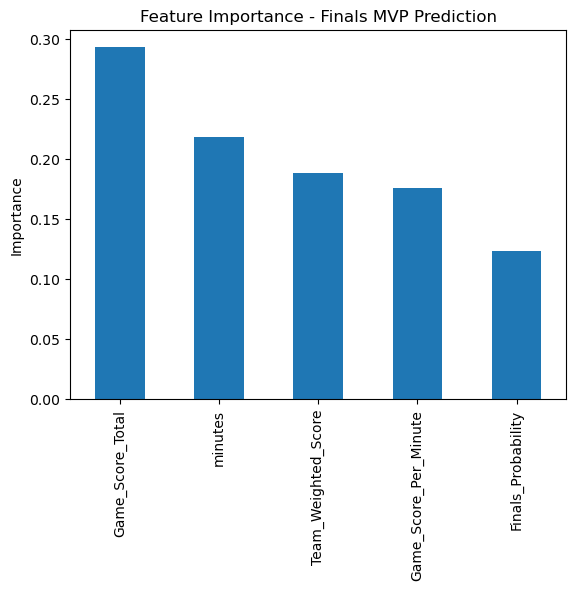

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature columns used in training
feature_cols = ["Game_Score_Total", "Game_Score_Per_Minute", "minutes",
                "Team_Weighted_Score", "Finals_Probability"]

# Get feature importances
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

# Print importance
print(feat_importance)

# Optional: plot
feat_importance.plot(kind='bar')
plt.title("Feature Importance - Finals MVP Prediction")
plt.ylabel("Importance")
plt.show()


### Overfitting

In [48]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Training predictions
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:,1]

# Testing predictions
y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)[:,1]

# Accuracy
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))

# AUC
print("Training AUC:", roc_auc_score(y_train, y_train_prob))
print("Testing AUC:", roc_auc_score(y_test, y_test_prob))


Training Accuracy: 1.0
Testing Accuracy: 0.9930795847750865
Training AUC: 1.0
Testing AUC: 0.8998257839721254
